# Compare different P1D measurements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=False,
#     line_length=79,
#     verbosity="DEBUG",
#     target_version=black.TargetVersion.PY310,
# )

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['figure.dpi'] = 160

from cup1d.data import data_Chabanier2019, data_Karacayli2022
from lace.archive.gadget_archive import GadgetArchive
from lace.archive.nyx_archive import NyxArchive

DEBUG:jupyter_black:Using config from /home/jchaves/Proyectos/projects/lya/cup1d/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

# Load data

### Read all P1D measurements

In [2]:
keys = ["label", "marker", "data"]
datasets = [
    dict(zip(keys, ["C19", "*", data_Chabanier2019.P1D_Chabanier2019()])),
    dict(zip(keys, ["K22", ".", data_Karacayli2022.P1D_Karacayli2022()])),
]

Nz = 14 , Nk = 13


### Read Gadget and Nyx

In [3]:
archive = GadgetArchive(postproc="Cabayol23")
mpg_central = archive.get_testing_data("mpg_central")

In [4]:
base_folder = "/home/jchaves/Proyectos/projects/lya/lya_pk/"
file_errors = "/data/std_pnd_mpg.npz"
err_mpg = np.load(base_folder + file_errors)["std_p1d"]

In [5]:
nyx_version = "Oct2023"
archive = NyxArchive(nyx_version=nyx_version)
nyx_central = archive.get_testing_data("nyx_central")
archive = 0

### Check redshifts

In [6]:
mpg_z = []
for sim in mpg_central:
    mpg_z.append(sim["z"])
mpg_z = np.array(mpg_z)

nyx_z = []
for sim in nyx_central:
    nyx_z.append(sim["z"])
nyx_z = np.array(nyx_z)

In [7]:
print(datasets[0]["data"].z)
print(datasets[1]["data"].z)
print(mpg_z[::-1])
print(nyx_z)

[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6]
[2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6]
[2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.   4.25 4.5 ]
[2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6 5.  5.4]


In [8]:
z_common = np.array([2.2, 3, 4])

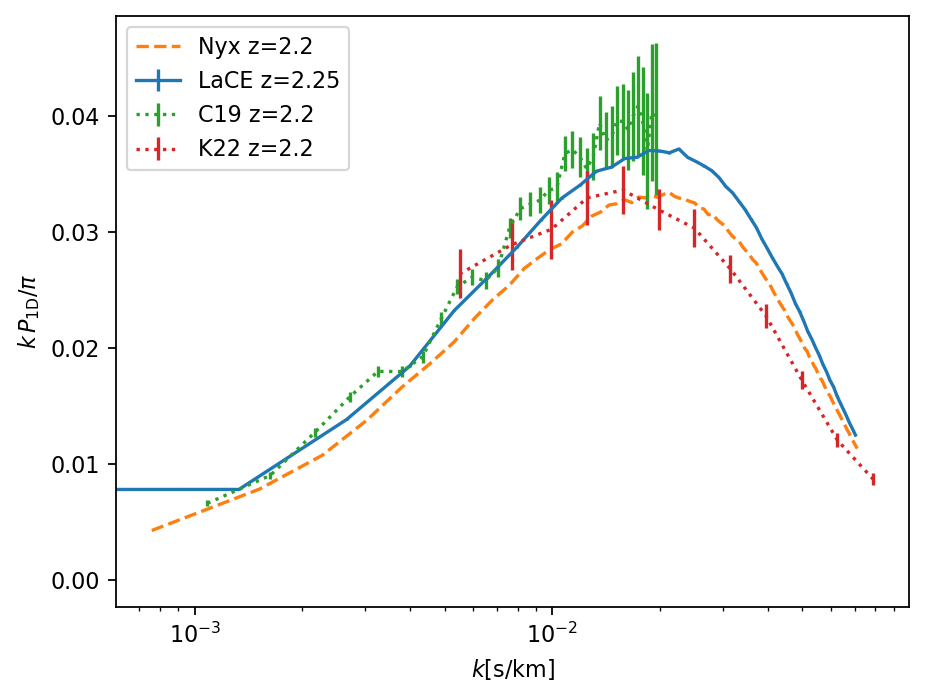

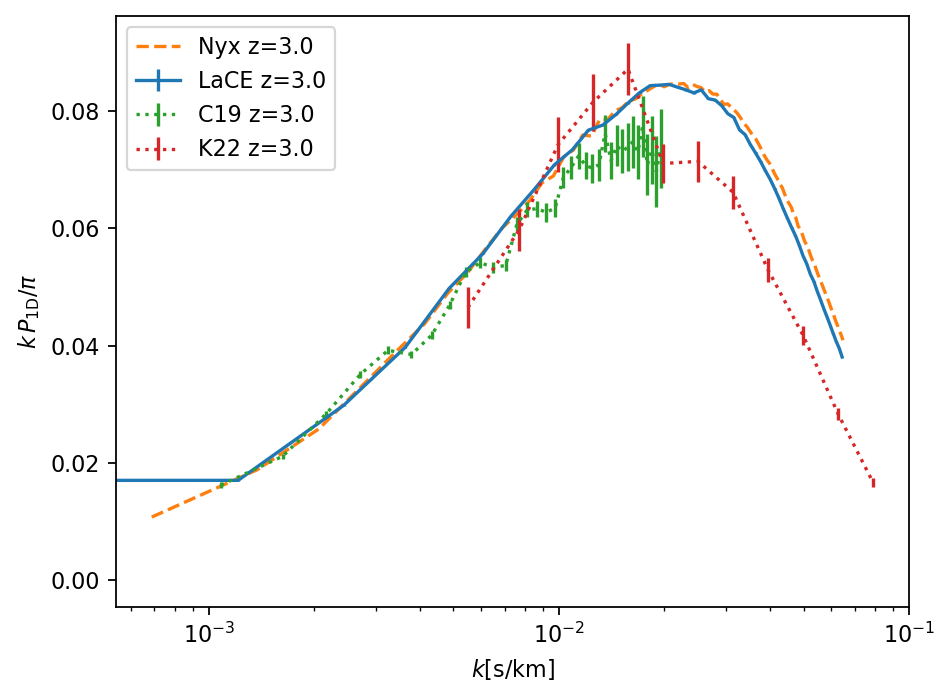

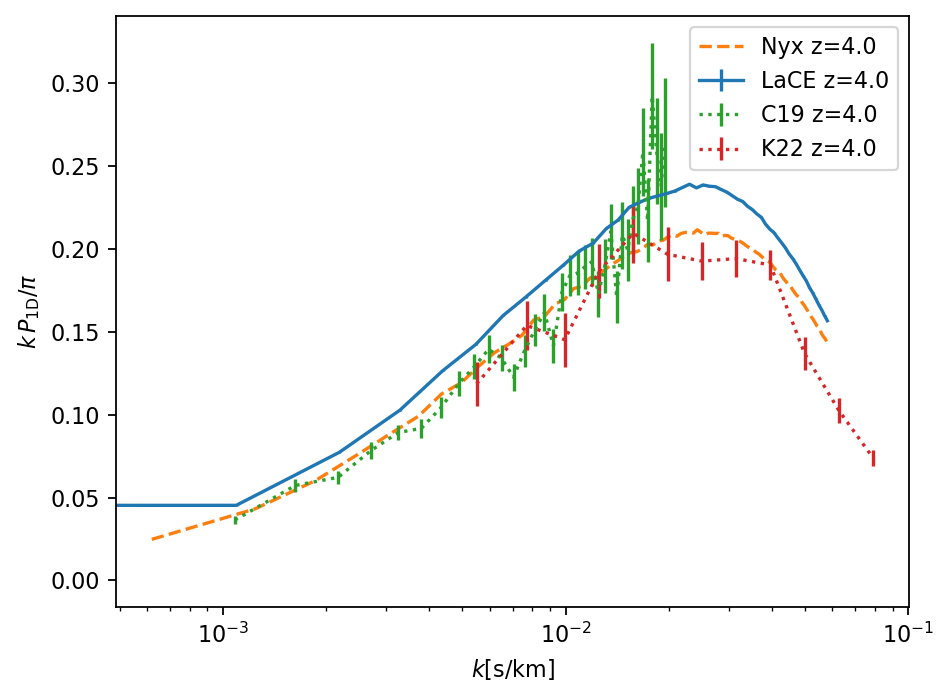

In [10]:
for ztarget in z_common:
    fig, ax = plt.subplots()

    # lace
    ii = np.argmin(np.abs(mpg_z - ztarget))
    mask = mpg_central[ii]["k_Mpc"] < 5
    conv_dkms_dMpc = mpg_central[ii]["dkms_dMpc"]
    k = mpg_central[ii]["k_Mpc"][mask]
    pk = mpg_central[ii]["p1d_Mpc"][mask]
    norm = k / np.pi
    std = err_mpg[mask] * pk
    ax.errorbar(
        k / conv_dkms_dMpc,
        norm * pk,
        norm * std,
        label="LaCE z=" + str(mpg_z[ii]),
    )
    #     if ztarget == 2.2:
    #         ii = ii + 1
    #         mask = mpg_central[ii]["k_Mpc"] < 5
    #         conv_dkms_dMpc = mpg_central[ii]["dkms_dMpc"]
    #         k = mpg_central[ii]["k_Mpc"][mask]
    #         pk = mpg_central[ii]["p1d_Mpc"][mask]
    #         norm = k / np.pi
    #         ax.plot(
    #             k / conv_dkms_dMpc,
    #             norm * pk,
    #             "C0:",
    #             label="LaCE z=" + str(mpg_z[ii]),
    #         )

    # nyx
    ii = np.argmin(np.abs(nyx_z - ztarget))
    mask = nyx_central[ii]["k_Mpc"] < 5
    conv_dkms_dMpc = nyx_central[ii]["dkms_dMpc"]
    k = nyx_central[ii]["k_Mpc"][mask]
    pk = nyx_central[ii]["p1d_Mpc"][mask]
    norm = k / np.pi
    ax.plot(
        k / conv_dkms_dMpc, norm * pk, "--", label="Nyx z=" + str(nyx_z[ii])
    )

    # eBOSS
    ii = np.argmin(np.abs(datasets[0]["data"].z - ztarget))
    k_kms = datasets[0]["data"].k_kms
    pk = datasets[0]["data"].get_Pk_iz(ii)
    err_pk = np.sqrt(np.diag(datasets[0]["data"].get_cov_iz(ii)))
    norm = k_kms / np.pi
    ax.errorbar(
        k_kms,
        norm * pk,
        norm * err_pk,
        ls=":",
        label="C19 z=" + str(datasets[0]["data"].z[ii]),
    )

    # high
    ii = np.argmin(np.abs(datasets[1]["data"].z - ztarget))
    k_kms = datasets[1]["data"].k_kms
    pk = datasets[1]["data"].get_Pk_iz(ii)
    err_pk = np.sqrt(np.diag(datasets[1]["data"].get_cov_iz(ii)))
    norm = k_kms / np.pi
    ax.errorbar(
        k_kms,
        norm * pk,
        norm * err_pk,
        ls=":",
        label="K22 z=" + str(datasets[1]["data"].z[ii]),
    )

    ax.set_xscale("log")
    ax.set_xlabel(r"$k$[s/km]")
    ax.set_ylabel(r"$k\,P_{\rm 1D}/\pi$")
    plt.legend()
#     plt.savefig('comparison_z'+str(ztarget)+'.png')
#     plt.savefig('comparison_z'+str(ztarget)+'.pdf')